In [3]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FRAME_ENABLED = 1

FRAME_THRESH_VALUE = 120
FRAME_THRESH_MAX = 200
FRAME_THRESH_TYPE = cv2.THRESH_BINARY_INV

FRAME_POLY_EPSILON = 0.01
FRAME_POLY_LENGTH = 4

FRAME_DILATE_KERNEL = (60,60)
FRAME_DILATE_IT = 1

FRAME_INDEX = -1
FRAME_COLOR = (250,0,1)
FRAME_THICKNESS = 15


folder = r"C:\Data"

extension = '.jpg'

names = [name for name in os.listdir(folder) if name.endswith(extension)]
filenames = [os.path.join(folder,name) for name in names]
images = [cv2.cvtColor(
    cv2.imread(filename, cv2.IMREAD_UNCHANGED), 
    cv2.COLOR_BGR2GRAY) for filename in filenames]

data = []
meta = []

for k,image in enumerate(images):
    
    name = names[k]

    i8 = image.copy() # Mono8

    rc,it = cv2.threshold(
        255-i8,
        thresh=FRAME_THRESH_VALUE,
        maxval=FRAME_THRESH_MAX,
        type=FRAME_THRESH_TYPE
        )
    id = cv2.dilate(it, kernel=np.ones(FRAME_DILATE_KERNEL, np.int8), iterations=FRAME_DILATE_IT)
    cc,h = cv2.findContours(id,1,2)

    aa = []
    ca = []
    for c in cc:
        
        a = cv2.approxPolyDP(c, epsilon=FRAME_POLY_EPSILON*cv2.arcLength(c,True), closed=True)
        
        if len(a) >= FRAME_POLY_LENGTH:

            r = cv2.minAreaRect(c)
            b = cv2.boxPoints(r)
            b = np.intp(b)
            
            aa.append(b)
            ca.append(cv2.contourArea(c))
    
    ic = cv2.cvtColor(i8,cv2.COLOR_GRAY2RGB)

    ca = np.array(ca) 

    if len(ca) >0:   
        
        ii = np.argsort(ca)[::-1]            
        aa = np.array(aa)[ii]
        ca = ca[ii]
        
        im = np.zeros_like(ic)
        cv2.fillPoly(im, [aa[0]], (255,255,255))

        print(aa[0])
                
        cv2.drawContours(
            image=ic,
            contours=aa,
            contourIdx=0,
            color=FRAME_COLOR,
            thickness=FRAME_THICKNESS
            )
        
        cv2.drawContours(
            image=ic,
            contours=aa[1:,:,:],
            contourIdx=-1,
            color=(102,102,102),
            thickness=FRAME_THICKNESS
            )
        
        im = cv2.bitwise_and(ic,im)
        
        lva = cv2.Laplacian(i8, cv2.CV_64F).var()
        
        meta.append(dict(
            name=name,
            area=ca[0],
            blur=lva,
            box=aa[0],
            avg=np.average(aa[0],axis=0)
            ))

    
    data.append(dict(
        ic=ic,
        i8=i8,
        id=id,
        im=im
        ))

data = np.array(data)
N = data.shape[0]

meta = pd.DataFrame(meta)
index = meta.index.to_list()

data = data[index]


[[2118  843]
 [2689  823]
 [2706 1277]
 [2134 1297]]
[[2151 3470]
 [2156  245]
 [2740  246]
 [2735 3471]]


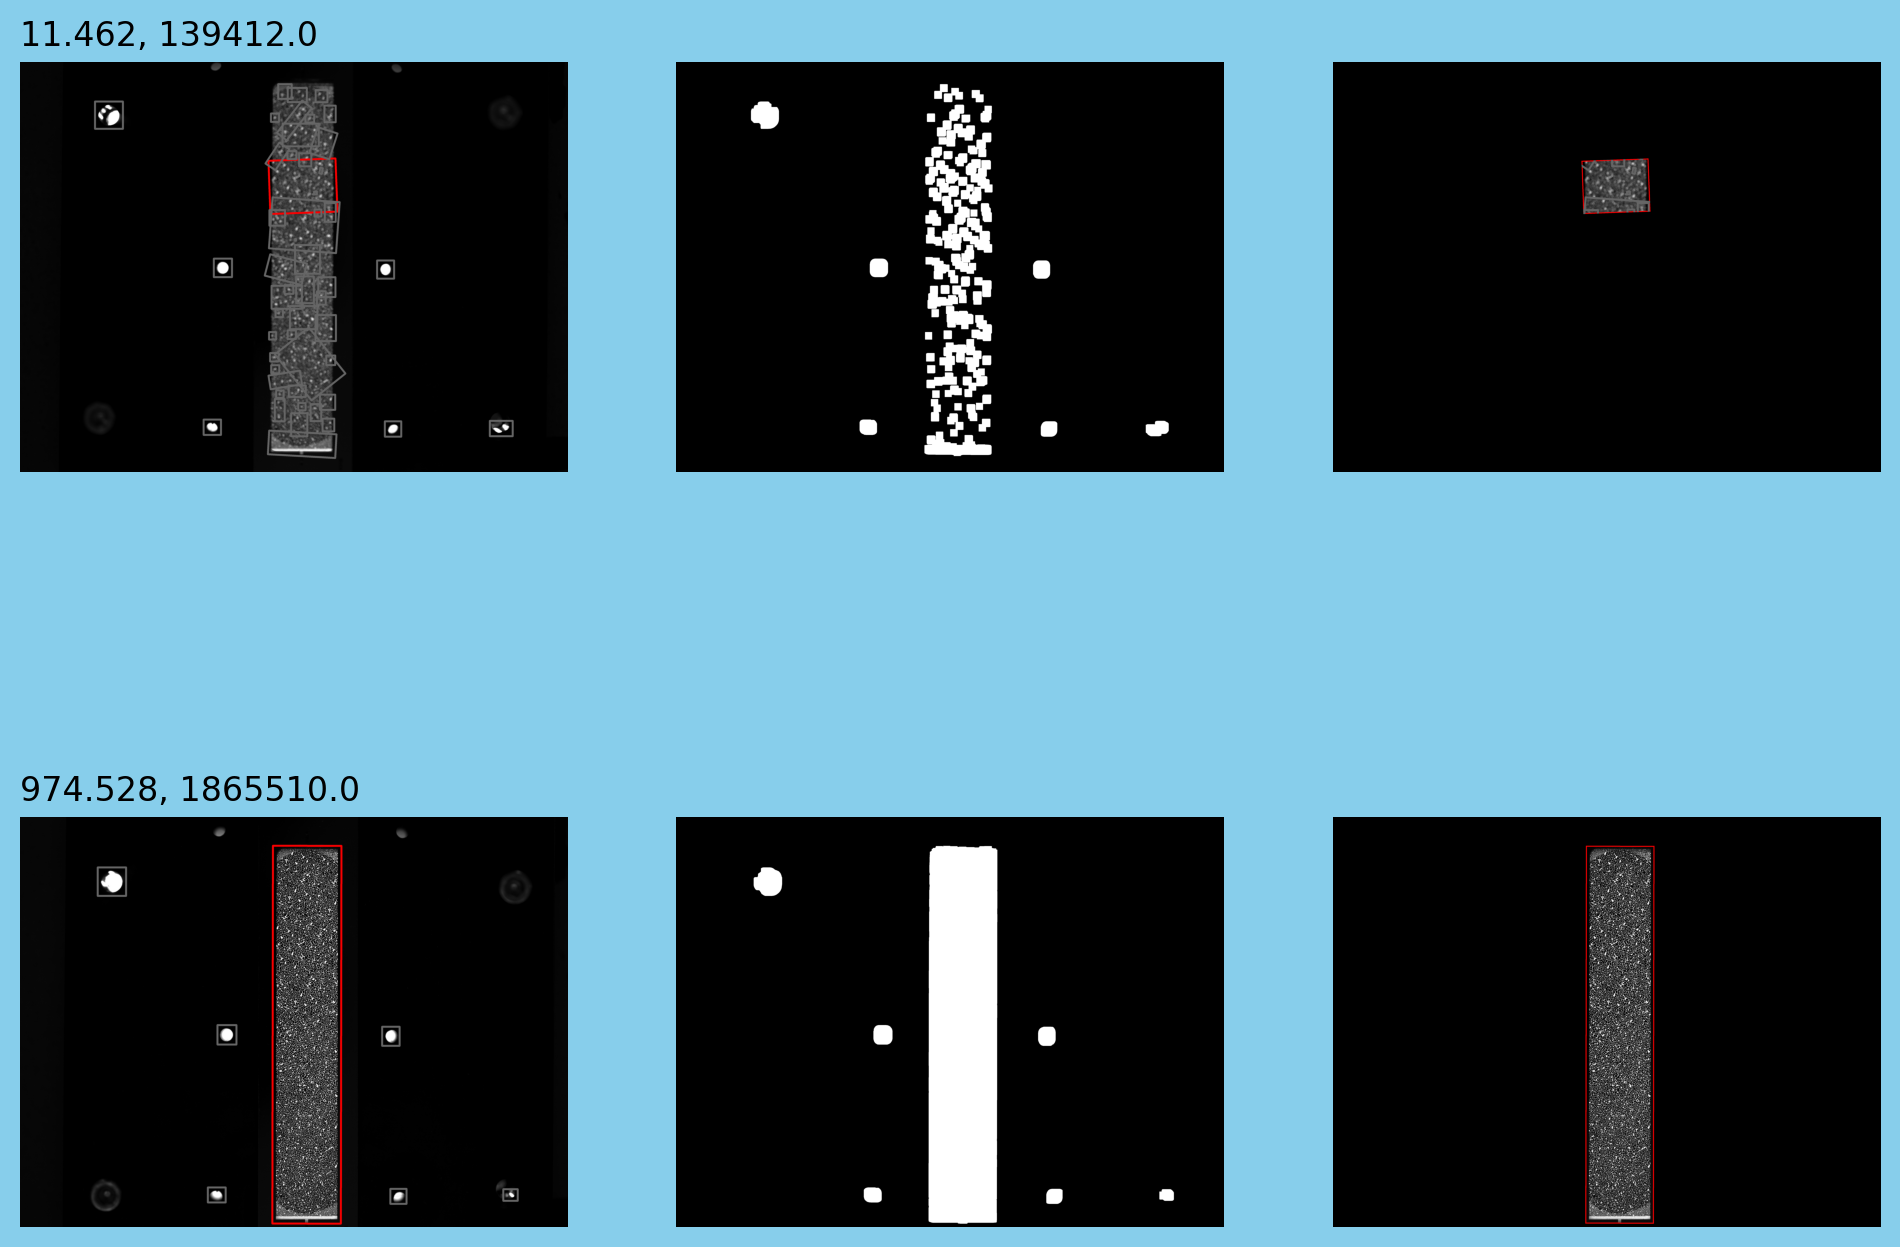

In [78]:

ncols = 3
nrows = N

shape = images[0].shape
f = shape[1]/shape[0]

w = 12
h = w*nrows / 2 / f

dpi = 200
plt.rcParams["figure.dpi"] = dpi
plt.rcParams['figure.figsize'] = [w,h]

fig, ax = plt.subplots(nrows=nrows,ncols=ncols)

fig.set_facecolor('skyblue')

for j in range(N):
    
    ax[j,0].imshow(data[j]['ic'])
    ax[j,1].imshow(data[j]['id'], cmap=plt.cm.gray)
    ax[j,2].imshow(data[j]['im'], cmap=plt.cm.gray)

    ax[j,0].set_title(f"{meta.loc[index[j],'blur']:.3f}, {meta.loc[index[j],'area']}", x=0, ha="left")   
    
for a_ in ax.ravel():
    a_.set_axis_off()

#plt.tight_layout()
plt.show()
plt.close()
